### This model uses the diffraction from overlapping sample regions to solve the inversion symmetry problem and improve reconstruction quality

misc notes:

clearing gpu memory: `for i in $(sudo lsof /dev/nvidia0 | grep python | awk '{print $2}' | sort -u); do sudo kill -9 $i; done`
https://github.com/tensorflow/tensorflow/issues/36465

In [1]:
%matplotlib inline

import os
from ptycho import tf_helper as hh
from ptycho import fourier as f
from ptycho import datasets
from ptycho.params import cfg
from ptycho.params import params

from sklearn.utils import shuffle

from importlib import reload
import os

import tensorflow as tf

import tensorflow_addons as tfa

import importlib
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
# from tqdm.notebook import tqdm as tqdm

from tensorflow.keras.layers import Layer
from math import pi
from tensorflow.keras import backend as K

matplotlib.rcParams['font.size'] = 12

2022-11-14 16:50:49.319900: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 16:50:49.405917: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 16:50:49.753015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2022-11-14 16:50:49.753061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
!nvidia-smi

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Nov 14 16:50:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   51C    P2   126W / 420W |   2660MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

### Some training and probe parameters

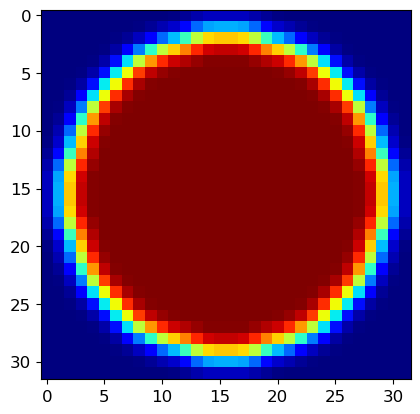

In [3]:
h = w = N = cfg['N'] = 64
# offset between neighboring scan points, in pixels
offset = cfg['offset'] = 4
gridsize = cfg['gridsize'] = 2

nepochs=20
#wt_path = 'wts4' #Where to store network weights
# wt_path = 'wts4.1'
batch_size = cfg['batch_size'] = 16

filt = f.lowpass_g(.55, np.ones(N), sym = True)
#filt = f.lowpass_g(.7, np.ones(N), sym = True)

# TODO assert symmetry
probe = f.gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 1) + 1e-9
probe_small = probe[16:-16, 16:-16]
tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])
cfg['probe'] = tprobe
tprobe_small = (tf.convert_to_tensor(probe_small, tf.float32)[..., None])

# if (not os.path.isdir(path+wt_path)):
#     os.mkdir(wt_path)

plt.imshow(tprobe_small, cmap = 'jet')

### Load experimental dataset

  0%|          | 0/161 [00:00<?, ?it/s]

101
(16100, 64, 64, 1) (3600, 64, 64, 1)
Instructions for updating:
ksizes is deprecated, use sizes instead


Instructions for updating:
ksizes is deprecated, use sizes instead


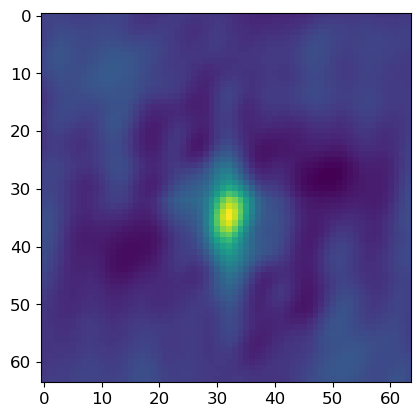

In [4]:
#from ptycho.experimental import *
from ptycho import experimental

### Simulate ptychography data

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


(TensorShape([121, 64, 64, 4]), TensorShape([10609, 64, 64, 4]))

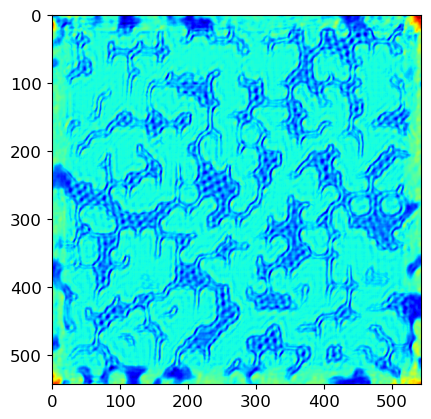

In [5]:
plt.imshow(experimental.inverted_patches_I[0, :, :, 0], cmap = 'jet')
#plt.imshow(inverted_patches_phi[0, :, :, 0], cmap = 'jet')

cfg['bigoffset'] = 4
X_train, Y_I_train, Y_phi_train, intensity_scale, _Y_I_train_full, _ = datasets.mk_expdata('train', probe)
cfg['intensity_scale'] = intensity_scale

cfg['bigoffset'] = ((gridsize - 1) * offset + N // 2)# // 2
bigN = N + (gridsize - 1) * offset
X_test, Y_I_test, Y_phi_test, _, _Y_I_test_full, norm_Y_I_test = datasets.mk_expdata('test', probe, intensity_scale)

# TODO shuffle should be after flatten
X_train, Y_I_train, Y_phi_train = shuffle(X_train.numpy(), Y_I_train.numpy(), Y_phi_train.numpy(), random_state=0)

(Y_I_test).shape, Y_I_train.shape

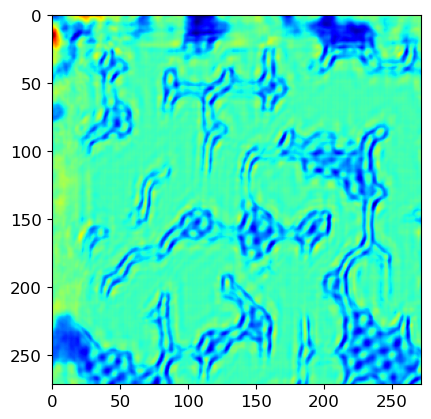

In [6]:
plt.imshow(_Y_I_train_full[0], cmap = 'jet')

In [8]:
print('intensity scale:', intensity_scale, '\n',
      'max photon count:', (np.max(Y_I_train, axis = (1, 2, 3)).mean() * intensity_scale)**2, '\n',
      'shapes:', (Y_phi_test).shape, (Y_I_test).shape, Y_I_train.shape)

intensity scale: 1698.6838 
 max photon count: 2561901.524849072 
 shapes: (121, 64, 64, 4) (121, 64, 64, 4) (10609, 64, 64, 4)


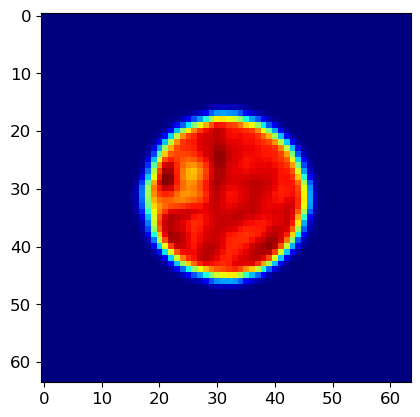

In [9]:
plt.imshow(Y_I_train[0, :, :, 0], cmap = 'jet')

### Norm conservation consistency check:

In [10]:
print(np.linalg.norm(X_train[0]) /  np.linalg.norm(Y_I_train[0]))

def normed_ff_np(arr):
    return (f.fftshift(np.absolute(f.fft2(np.array(arr)))) / np.sqrt(h * w))

0.9999978


### Inversion symmetry check:

In [11]:
assert np.isclose(normed_ff_np(Y_I_train[0, :, :, 0]),
            tf.math.conj(normed_ff_np(Y_I_train[0, ::-1, ::-1, 0])), atol = 1e-6).all()

#normed_ff_np(Y_I_train[0, :, :, 0]).sum() / normed_ff_np(Y_I_train[0, :, :, 0]).sum()

### np / tf consistency check:

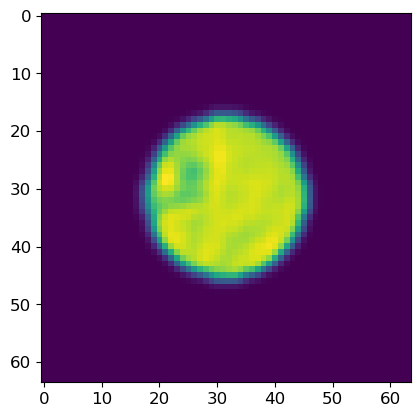

In [12]:
plt.imshow(Y_I_train[0, :, :, 0])

### Number of photons consitency check

In [13]:
np.log10(np.sum((X_train[:, :, :] * intensity_scale)**2, axis = (1, 2))).mean()

8.997815

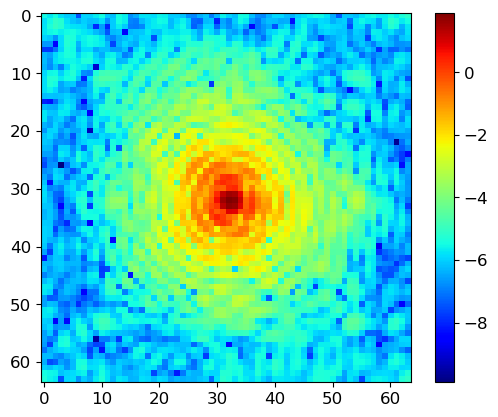

In [14]:
i = 1

plt.imshow(np.log(normed_ff_np
                  (np.array(hh.combine_complex(Y_I_train, Y_phi_train))[0, :, :, 0])), cmap = 'jet')
plt.colorbar()

/tmp/ipykernel_671127/1841061669.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_train[0, :, :, 0]), cmap = 'jet')


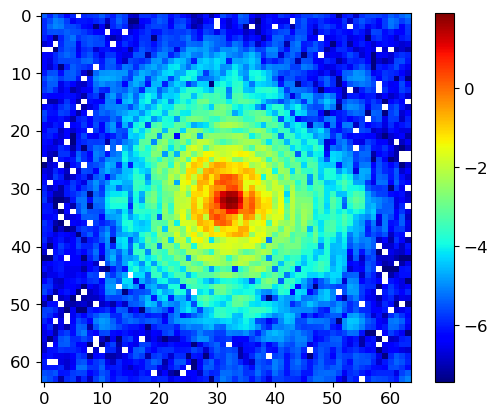

In [15]:
plt.imshow(np.log(X_train[0, :, :, 0]), cmap = 'jet')
plt.colorbar()

## Define the network structure

In [33]:
plt.rcParams["figure.figsize"] = (10, 10)

In [42]:
from ptycho import model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   1184        ['input[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

None


In [47]:
history = model.train(20, X_train, Y_I_train)
b, a, reg, L2_error = model.autoencoder.predict([X_test])

Epoch 1/20
Cause: could not parse the source code of <function <lambda> at 0x7fb4c97a5940>: no matching AST found among candidates:
# coding=utf-8
lambda x: sigmoid(x)
# coding=utf-8
lambda x: math.pi * tanh(x)
# coding=utf-8
lambda x: hh.combine_complex(x[0], x[1])
# coding=utf-8
lambda x: hh.flatten_overlaps(x, fmt='flat')
# coding=utf-8
lambda x: tf.cast(tprobe, tf.complex64) * x
# coding=utf-8
lambda x: hh._flat_to_channel(x)
# coding=utf-8
lambda t: tfd.Independent(tfd.Poisson((t * intensity_scale) ** 2))
# coding=utf-8
lambda x, rv_x: -rv_x.log_prob(x)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb4c97a5940>: no matching AST found among candidates:
# coding=utf-8
lambda x: sigmoid(x)
# coding=utf-8
lambda x: math.pi * tanh(x)
# coding=utf-8
lambda x: hh.combine_complex(x[0], x[1])
# coding=utf-8
lambda x: hh.flatten_overlaps(x, fmt='flat')
# coding=utf-8
lambda x: tf.cast(tprobe, tf.complex64) * x
# coding=utf-8
lambda x: hh._flat_to_channel(x)
# coding=utf-8
lambda t: tfd.Independent(tfd.Poisson((t * intensity_scale) ** 2))
# coding=utf-8
lambda x, rv_x: -rv_x.log_prob(x)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb4c97a5940>: no matching AST found among candidates:
# coding=utf-8
lambda x: sigmoid(x)
# coding=utf-8
lambda x: math.pi * tanh(x)
# coding=utf-8
lambda x: hh.combine_complex(x[0], x[1])
# coding=utf-8
lambda x: hh.flatten_overlaps(x, fmt='flat')
# coding=utf-8
lambda x: tf.cast(tprobe, tf.complex64) * x
# coding=utf-8
lambda x: hh._flat_to_channel(x)
# coding=utf-8
lambda t: tfd.Independent(tfd.Poisson((t * intensity_scale) ** 2))
# coding=utf-8
lambda x, rv_x: -rv_x.log_prob(x)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-11-14 17:11:13.440244: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


630/630 [==============================] - ETA: 0s - loss: 548719488.0000 - padded_obj_loss: 0.1658 - pred_diff_channels_loss: 0.0218 - distribution_lambda_loss: 548719488.0000 - pred_diff_channels_1_loss: 0.0786
Epoch 1: val_loss improved from inf to 347304416.00000, saving model to wts4.1/weights.01.h5
630/630 [==============================] - 11s 14ms/step - loss: 548719488.0000 - padded_obj_loss: 0.1658 - pred_diff_channels_loss: 0.0218 - distribution_lambda_loss: 548719488.0000 - pred_diff_channels_1_loss: 0.0786 - val_loss: 347304416.0000 - val_padded_obj_loss: 0.1697 - val_pred_diff_channels_loss: 0.0197 - val_distribution_lambda_loss: 347304416.0000 - val_pred_diff_channels_1_loss: 0.0810 - lr: 0.0010
Epoch 2/20
630/630 [==============================] - ETA: 0s - loss: 316170592.0000 - padded_obj_loss: 0.1808 - pred_diff_channels_loss: 0.0183 - distribution_lambda_loss: 316170592.0000 - pred_diff_channels_1_loss: 0.0809
Epoch 2: val_loss improved from 347304416.00000 to 29834

627/630 [============================>.] - ETA: 0s - loss: 37443208.0000 - padded_obj_loss: 0.2528 - pred_diff_channels_loss: 0.0106 - distribution_lambda_loss: 37443208.0000 - pred_diff_channels_1_loss: 0.0837
Epoch 12: val_loss improved from 52971624.00000 to 38670148.00000, saving model to wts4.1/weights.12.h5
630/630 [==============================] - 8s 12ms/step - loss: 37436540.0000 - padded_obj_loss: 0.2528 - pred_diff_channels_loss: 0.0106 - distribution_lambda_loss: 37436540.0000 - pred_diff_channels_1_loss: 0.0837 - val_loss: 38670148.0000 - val_padded_obj_loss: 0.2500 - val_pred_diff_channels_loss: 0.0107 - val_distribution_lambda_loss: 38670148.0000 - val_pred_diff_channels_1_loss: 0.0822 - lr: 5.0000e-04
Epoch 13/20
627/630 [============================>.] - ETA: 0s - loss: 34755928.0000 - padded_obj_loss: 0.2538 - pred_diff_channels_loss: 0.0104 - distribution_lambda_loss: 34755928.0000 - pred_diff_channels_1_loss: 0.0837
Epoch 13: val_loss did not improve from 38670148.

In [35]:
# %timeit diffraction_to_obj.predict([X_test])

4/4 [==============================] - 0s 3ms/step
35.8 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit autoencoder.predict([X_test])

In [99]:
# plt.plot(np.array(history.history['val_loss']))
# plt.semilogy()

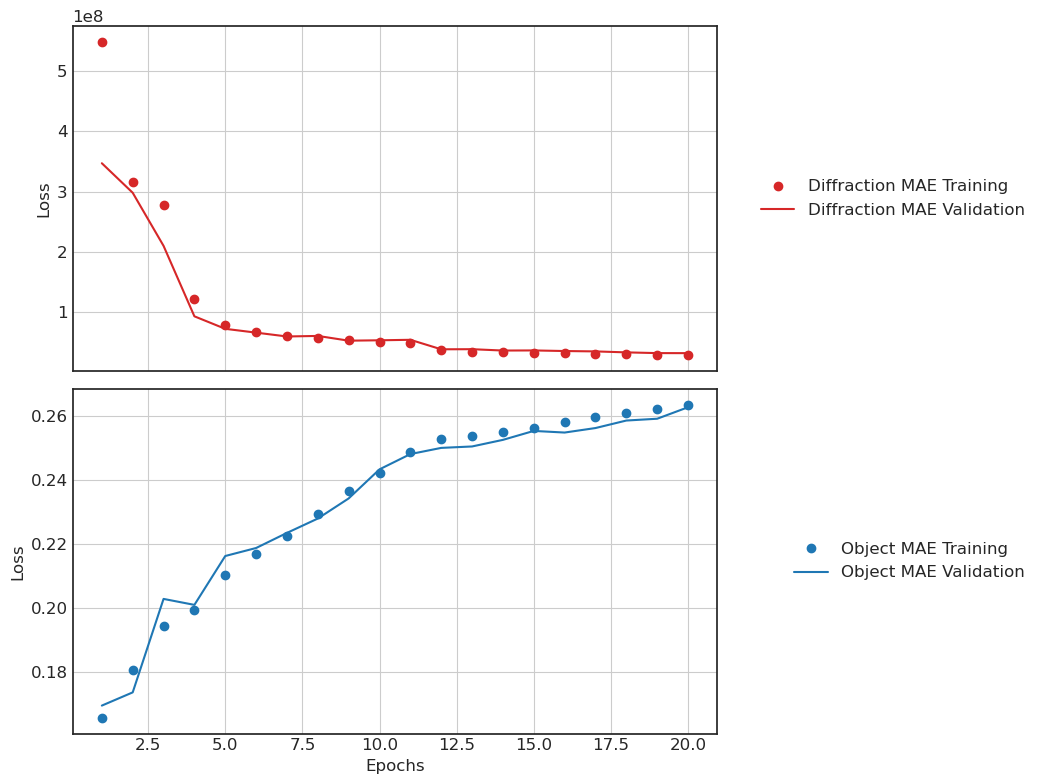

In [100]:
from ptycho import evaluation
reload(evaluation)

evaluation.plt_metrics(history)

/home/ollie/Documents/scratch/ptycho/ptycho/evaluation.py:49: RuntimeWarning: divide by zero encountered in log
  plt.subplot(aa, bb, 8)


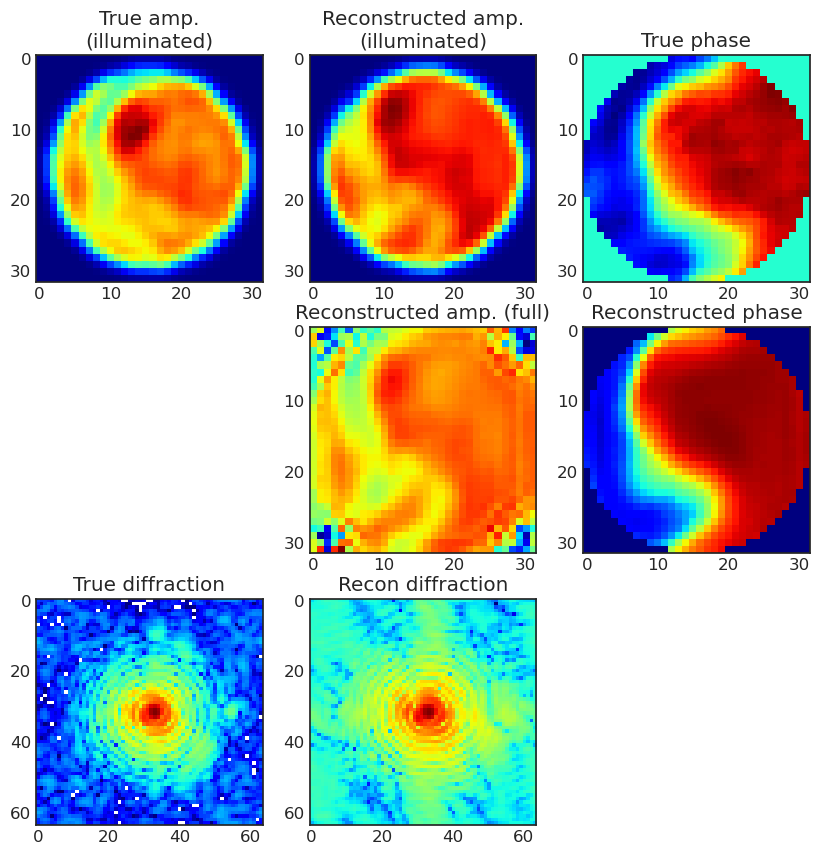

In [64]:
#plt_metrics()
evaluation.summarize(10, a, b, X_test, Y_I_test, Y_phi_test, probe, 0)

## Evaluate resolution

In [234]:
np.random.seed(2)
Y_I_2, Y_phi_2, _Y_I_full_2 = simulate_objects(12)

line = np.zeros_like(Y_I_2)
line[:, 31, :, :] = .1
line = f.gf(line, (0, 1, 1, 0))

X_2, Y_I_2, Y_phi_2, _ =\
    illuminate_and_diffract(Y_I_2 + line, Y_phi_2, intensity_scale = intensity_scale)

plt.imshow((Y_I_2 - Y_I_test)[0, :, :, 0])
plt.colorbar()

b2, _, _, _ = autoencoder.predict([X_2])
difference = np.real(b2 - b).mean(axis = 0)

plt.imshow(difference, cmap = 'jet')

lineout_orig = line[0, :, :, 0].sum(axis = 1)
lineout_recon = difference[:, :, 0].sum(axis = 1)

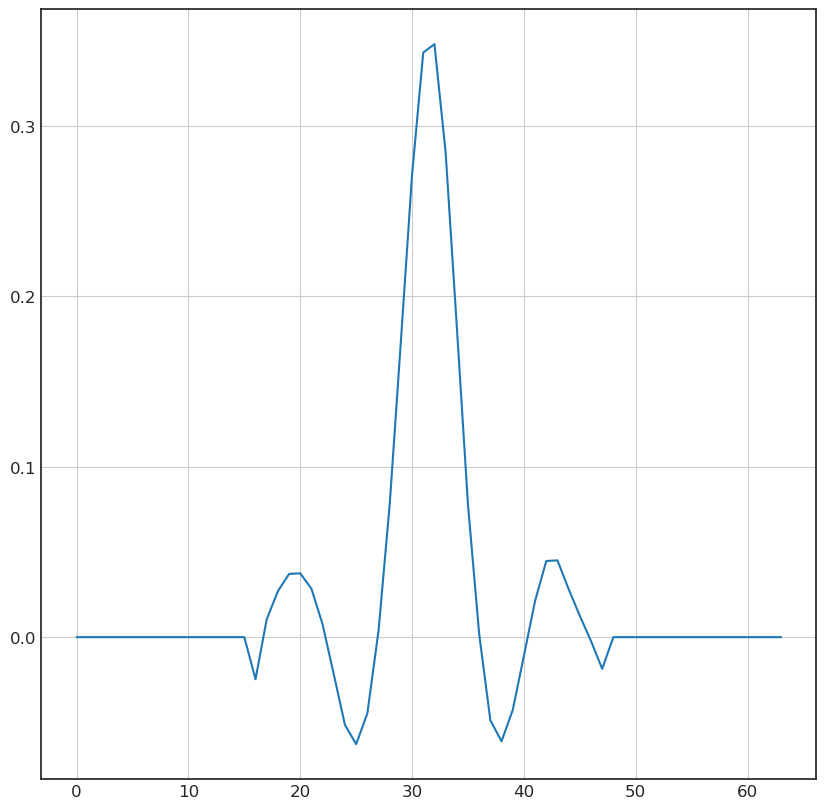

In [251]:
%matplotlib inline
#plt.plot(lineout_orig)
plt.plot(lineout_recon)
plt.grid()

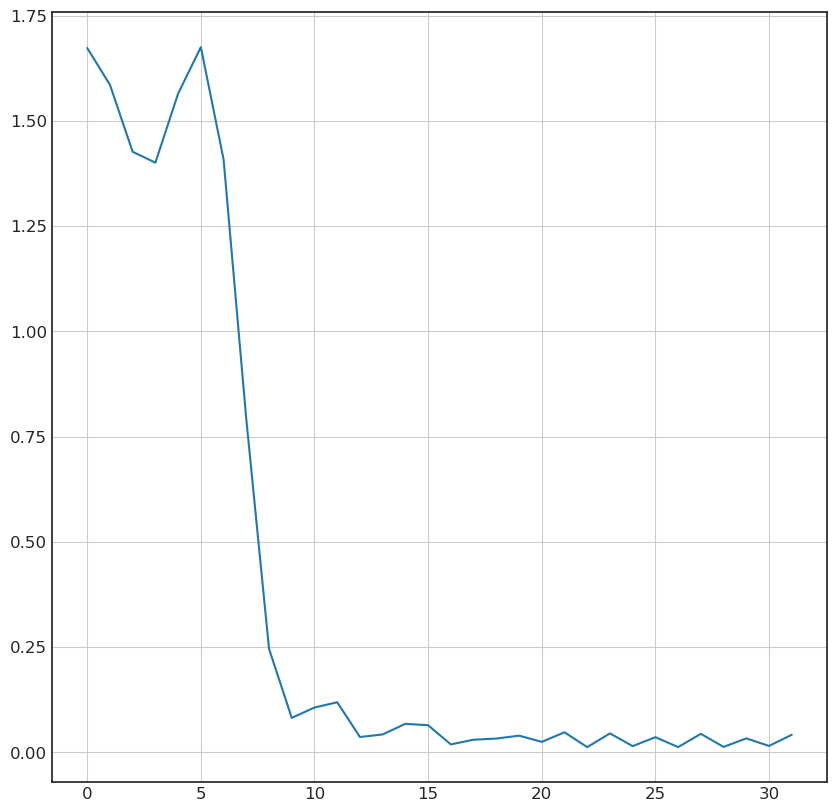

In [253]:
plt.plot(np.abs(f.fftshift(f.fft(lineout_recon)))[32:])
# plt.plot(np.abs(f.fftshift(f.fft(lineout_orig)))[32:])
plt.grid()

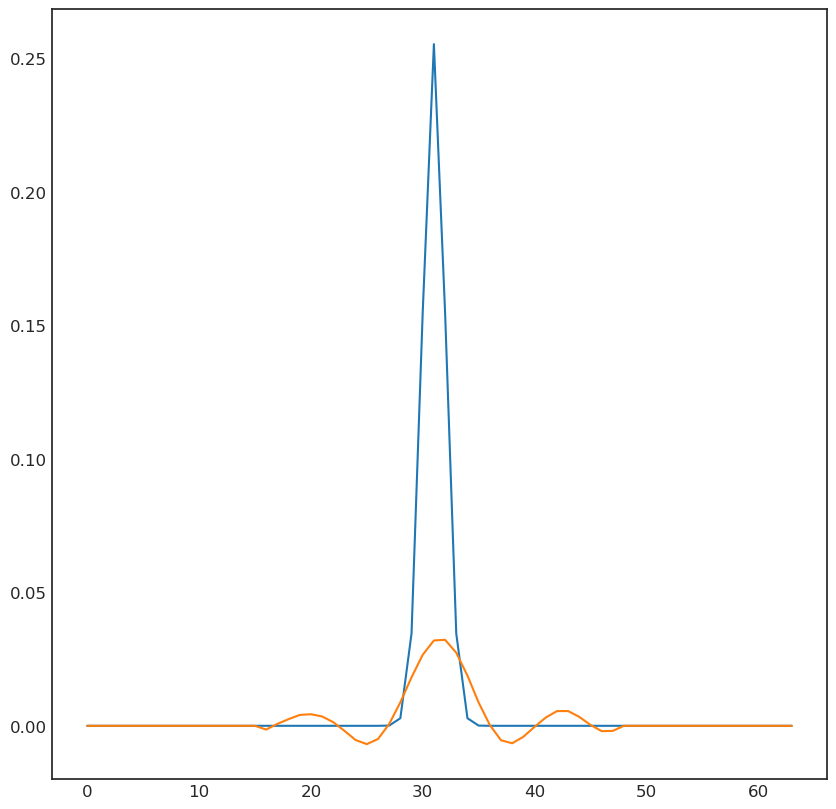

In [205]:
lineout_orig = line[0, :, :, 0].sum(axis = 1)

lineout_recon = difference[:, :, 0].sum(axis = 1)

plt.plot(lineout_orig)
plt.plot(lineout_recon)

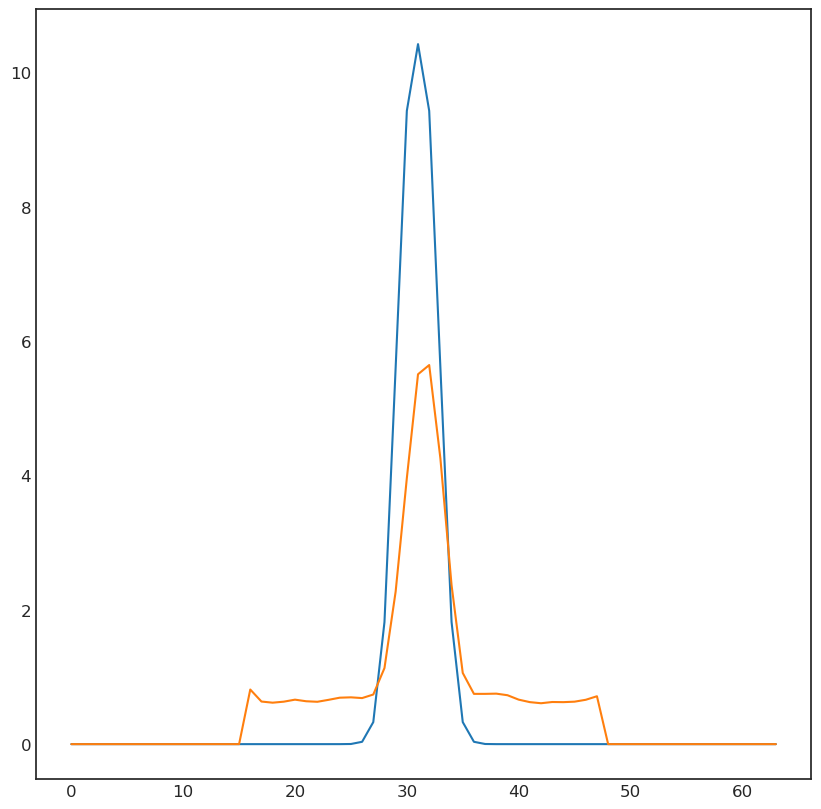

In [97]:
lineout_orig = line[0, :, :, 0].sum(axis = 1)

lineout_recon = difference[:, :, 0].sum(axis = 1)

plt.plot(lineout_orig)
plt.plot(lineout_recon)

In [71]:
from ptycho import baselines as bl

In [75]:
big_gridsize = 10
bigoffset = params()['bigoffset']

bordersize = N // 2 - bigoffset // 4
clipsize = (bordersize + ((gridsize - 1) * offset) // 2)

def stitch(b, norm_Y_I_test = 1, nsegments = big_gridsize * 2 - 1):
    img_recon = np.reshape((norm_Y_I_test * np.absolute(b)), (-1, nsegments,
                                                              nsegments, 64, 64, 1))
    img_recon = img_recon[:, :, :, bordersize: -bordersize, bordersize: -bordersize, :]
    tmp = img_recon.transpose(0, 1, 3, 2, 4, 5)
    stitched = tmp.reshape(-1, np.prod(tmp.shape[1:3]), np.prod(tmp.shape[1:3]), 1)
    return stitched

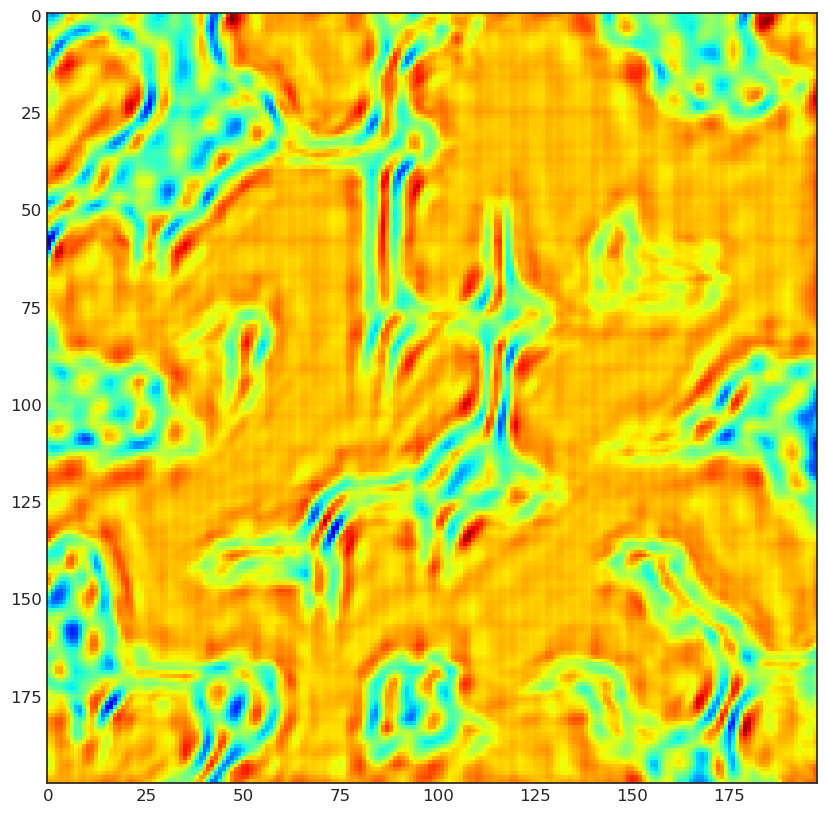

In [76]:
bordersize = N // 2 - bigoffset // 4
clipsize = (bordersize + ((gridsize - 1) * offset) // 2)

plt.imshow(_Y_I_test_full[0, clipsize: -clipsize, clipsize: -clipsize], interpolation = 'none',
          cmap = 'jet')
vmin = np.min(_Y_I_test_full[0, clipsize: -clipsize, clipsize: -clipsize])
vmax = np.max(_Y_I_test_full[0, clipsize: -clipsize, clipsize: -clipsize])

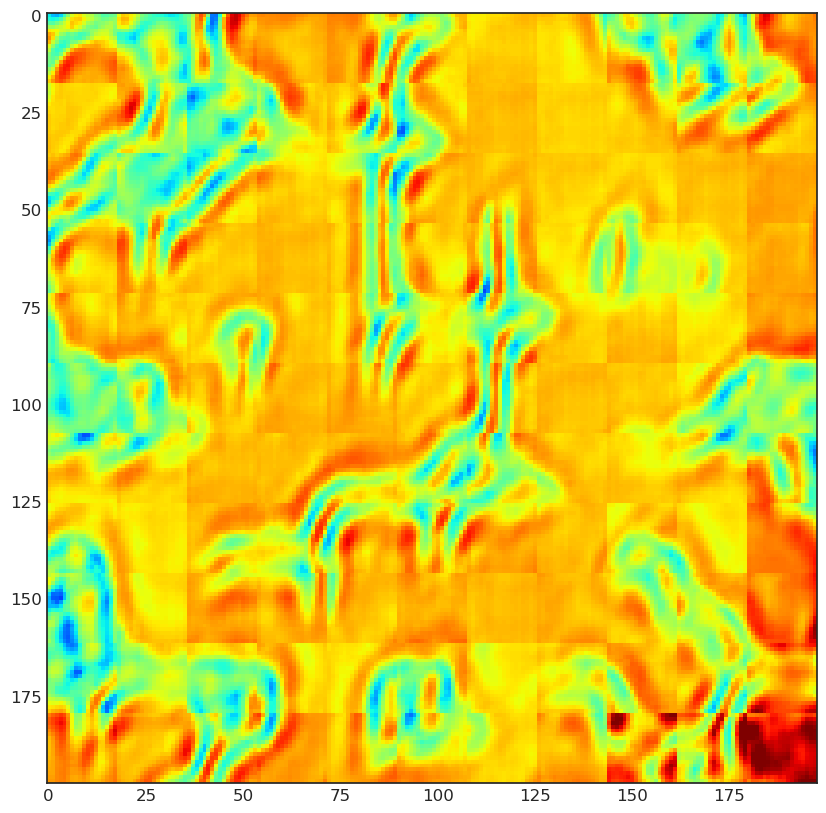

In [78]:
plt.rcParams["figure.figsize"] = (10, 10)

stitched = stitch(b, norm_Y_I_test, nsegments=11)

plt.imshow(stitched[0], interpolation = 'none', vmin = vmin, vmax = vmax, cmap = 'jet')

In [79]:
baseline_model = bl.train((X_train[:, :, :, :1]), Y_I_train[:, :, :, :1], Y_phi_train[:, :, :, :1])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

315/315 [==============================] - 4s 12ms/step - loss: 0.2854 - conv2d_12_loss: 0.0074 - conv2d_19_loss: 0.2780 - val_loss: 0.2815 - val_conv2d_12_loss: 0.0070 - val_conv2d_19_loss: 0.2745 - lr: 0.0010
Epoch 9/60
315/315 [==============================] - 4s 12ms/step - loss: 0.2672 - conv2d_12_loss: 0.0071 - conv2d_19_loss: 0.2600 - val_loss: 0.2857 - val_conv2d_12_loss: 0.0071 - val_conv2d_19_loss: 0.2785 - lr: 0.0010
Epoch 10/60
315/315 [==============================] - 4s 12ms/step - loss: 0.2521 - conv2d_12_loss: 0.0068 - conv2d_19_loss: 0.2452 - val_loss: 0.2576 - val_conv2d_12_loss: 0.0067 - val_conv2d_19_loss: 0.2509 - lr: 0.0010
Epoch 11/60
315/315 [==============================] - 4s 12ms/step - loss: 0.2342 - conv2d_12_loss: 0.0064 - conv2d_19_loss: 0.2278 - val_loss: 0.2364 - val_conv2d_12_loss: 0.0061 - val_conv2d_19_loss: 0.2303 - lr: 0.0010
Epoch 12/60
315/315 [==============================] - 4s 12ms/step - loss: 0.2221 - conv2d_12_loss: 0.0060 - conv2d_19_l

Epoch 43/60
311/315 [============================>.] - ETA: 0s - loss: 0.0764 - conv2d_12_loss: 0.0026 - conv2d_19_loss: 0.0738
Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
315/315 [==============================] - 4s 12ms/step - loss: 0.0764 - conv2d_12_loss: 0.0026 - conv2d_19_loss: 0.0738 - val_loss: 0.1068 - val_conv2d_12_loss: 0.0033 - val_conv2d_19_loss: 0.1035 - lr: 2.5000e-04
Epoch 44/60
315/315 [==============================] - 4s 12ms/step - loss: 0.0728 - conv2d_12_loss: 0.0025 - conv2d_19_loss: 0.0703 - val_loss: 0.1043 - val_conv2d_12_loss: 0.0033 - val_conv2d_19_loss: 0.1011 - lr: 1.2500e-04
Epoch 45/60
315/315 [==============================] - 4s 12ms/step - loss: 0.0716 - conv2d_12_loss: 0.0025 - conv2d_19_loss: 0.0691 - val_loss: 0.1041 - val_conv2d_12_loss: 0.0033 - val_conv2d_19_loss: 0.1008 - lr: 1.2500e-04
Epoch 46/60
315/315 [==============================] - 4s 12ms/step - loss: 0.0710 - conv2d_12_loss: 0.0025 - conv2d_19_loss: 

4/4 [==============================] - 0s 4ms/step


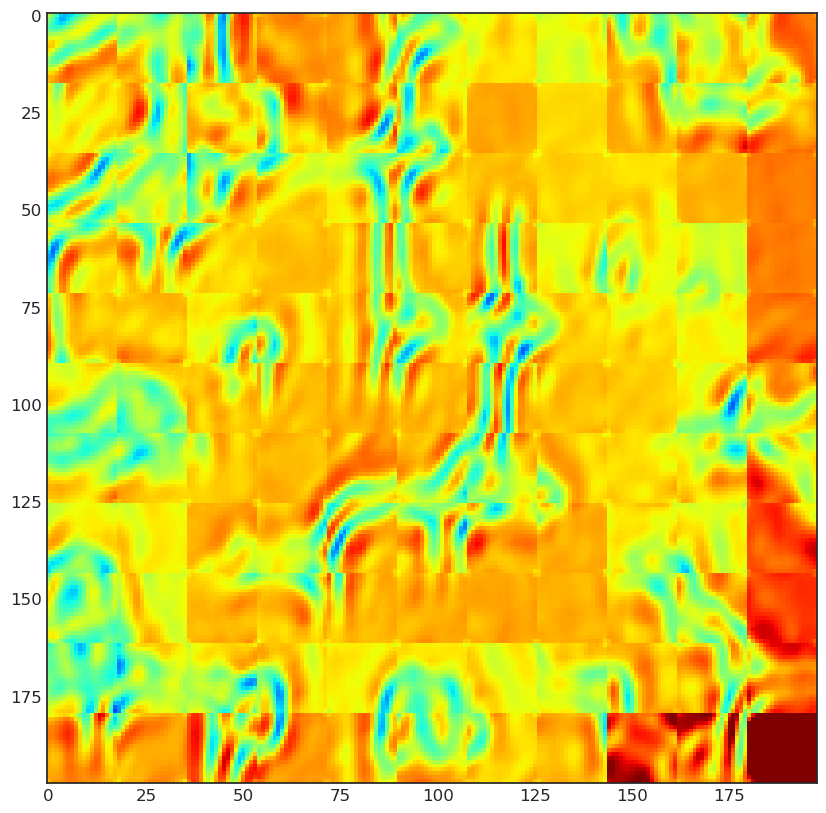

In [83]:
baseline_pred_I, baseline_pred_phi = baseline_model.predict([X_test[:, :, :, 0]])
baseline_stitched = stitch(baseline_pred_I, norm_Y_I_test, nsegments=11)

plt.imshow(baseline_stitched[0], cmap = 'jet', vmin = vmin, vmax = vmax)

In [85]:
gt = _Y_I_test_full[:, clipsize: -clipsize, clipsize: -clipsize]
tf.keras.losses.MeanAbsoluteError()(gt, stitched)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0040464187>

In [86]:
tf.keras.losses.MeanSquaredError()(gt, stitched)

<tf.Tensor: shape=(), dtype=float32, numpy=3.37226e-05>

In [87]:
tf.keras.losses.MeanAbsoluteError()(gt, baseline_stitched)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0077292537>

In [88]:
tf.keras.losses.MeanSquaredError()(gt, baseline_stitched)

<tf.Tensor: shape=(), dtype=float32, numpy=0.00013008271>

In [89]:
baseline_model.evaluate([X_test[:, :, :, 0]])

4/4 [==============================] - 0s 806us/step - loss: 0.0000e+00 - conv2d_12_loss: 0.0000e+00 - conv2d_19_loss: 0.0000e+00


[0.0, 0.0, 0.0]

In [90]:
i = 0
# consistency check: should be close to equal
np.sum(tf.math.abs(a[i])**2), np.sum(tf.math.abs(X_test[i])**2),\
np.sum(tf.math.abs(a)**2), np.sum(tf.math.abs(X_test)**2)

(1296.268, 1232.1055, 163924.03, 164390.33)

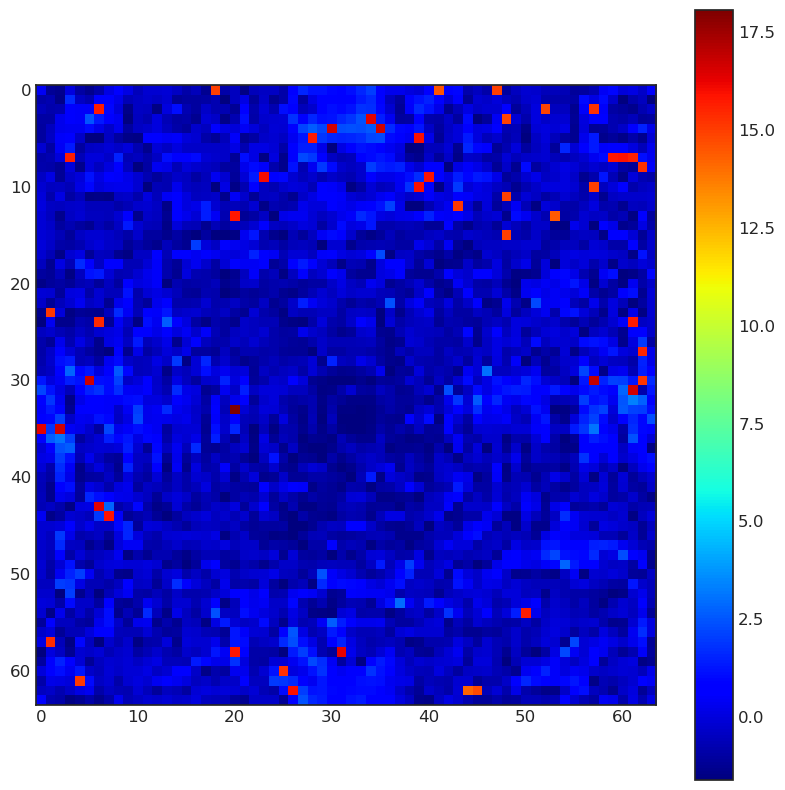

In [91]:
plt.imshow(np.log(.2 + np.abs((a[i, :, :, 0] - X_test[i, :, :, 0]) / (X_test[i, :, :, 0] + 1e-9))), cmap ='jet')
plt.colorbar()

In [93]:
# off = 1
# vmin = 0
# vmax = 1

# aa, bb = 1, 2
# plt.subplot(aa, bb, 1)
# plt.title('Ground truth amp.')
# cropshow((Y_I_test[i, :, :, 0]), cmap = 'jet', vmin = vmin, vmax = vmax)

# plt.subplot(aa, bb, 2)
# plt.title('Reconstructed amp.')
# cropshow((np.absolute(b))[i, :, :, 0], cmap = 'jet', vmin = vmin, vmax = vmax)

In [95]:
# !ln ../xrd_clustering/notebooks/visualization.py
from ptycho import visualization as vis
reload(vis)

<module 'ptycho.visualization' from '/home/ollie/Documents/scratch/ptycho/ptycho/visualization.py'>

diffraction reconstruction


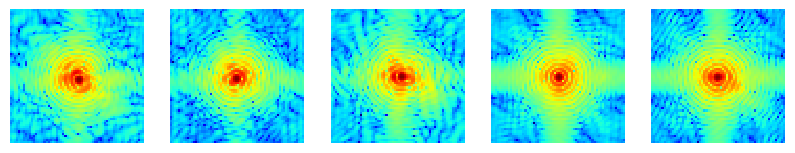

diffraction ground truth


/tmp/ipykernel_671127/1178352548.py:10: RuntimeWarning: divide by zero encountered in log
  vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + off])


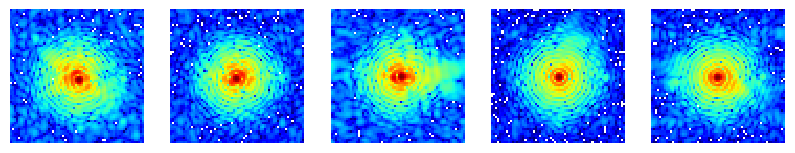

object reconstruction (amp)


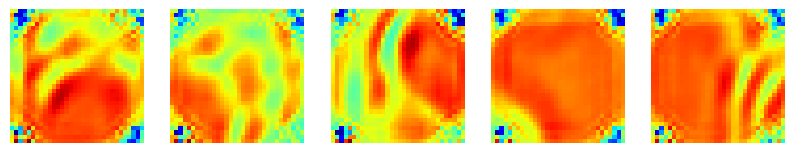

object ground truth


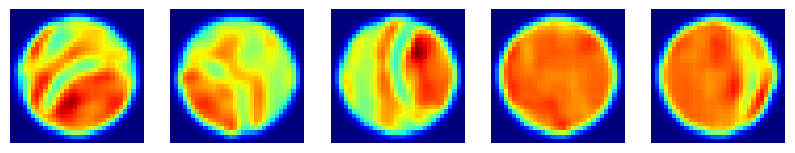

In [96]:
off = 5

vmin = np.min(Y_I_test[:, 16:-16, 16:-16][i:i + off])
vmax = np.max(Y_I_test[:, 16:-16, 16:-16][i:i + off])

print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a[:, :, :, 0]))[i:i + off])

print('diffraction ground truth')
vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + off])

print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16, 0])[i:i + off], vmin = vmin, vmax = vmax)
# print('object reconstruction (phase)')
# vis.display_imgs(np.angle(b[:, 16:-16, 16:-16, 0])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16, 0][i:i + off], vmin = vmin, vmax = vmax)

## save model

In [249]:
history.history.keys()

dict_keys(['loss', 'pred_amplitude_loss', 'padded_obj_loss', 'pred_amplitude_1_loss', 'val_loss', 'val_pred_amplitude_loss', 'val_padded_obj_loss', 'val_pred_amplitude_1_loss', 'lr'])

In [250]:
np.save(path+'str_history', history.history)

In [251]:
# model.load_weights(checkpoint_filepath)

In [68]:
# val_losses=hist.history['val_loss']
# min_epoch=np.argmin(val_losses)+1
# print (min_epoch)
# np.save(path+'%s/min_epoch' %(wt_path), min_epoch)
autoencoder.save('{}.h5'.format(wt_path))